# Basic VAE

In [1]:
import os
import torch as t
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
try: # One-time setup
    assert(_SETUP)
except NameError:
    while not '.git' in os.listdir():
        os.chdir("../")
    device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")
    if device == t.device("cuda"):
        !nvidia-smi
    else:
        print('CUDA is unavailable; training on CPU.')
    _SETUP = True

Thu Aug 12 18:05:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8    N/A /  N/A |     11MiB /  4042MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Utility functions

In [13]:
def load_mnist(batch_size: int = 64) -> tuple[DataLoader, DataLoader]:
    """(Down)load MNIST dataset in ./data/testdata, and return training and
    test DataLoaders using specified batch_size.
    """

    cuda_kwargs = {'num_workers': 1} #, 'pin_memory': True}
    train_kwargs = {'batch_size': batch_size, 'shuffle': True} | cuda_kwargs
    test_kwargs = {'batch_size': batch_size, 'shuffle': False} | cuda_kwargs

    transform = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_set = datasets.MNIST('./data/testdata', train=True, download=True, 
                               transform=transform)
    test_set = datasets.MNIST('./data/testdata', train=False, download=True, 
                              transform=transform)

    train_loader = DataLoader(train_set, **train_kwargs)
    test_loader = DataLoader(test_set, **test_kwargs)

    return train_loader, test_loader

def onehot(idx: t.Tensor, n: int) -> t.Tensor:
    """Turns an index into a one-hot encoded vector, of length n"""
    assert t.max(idx).item() < n
    
    if idx.dim() == 1:
        idx = idx.unsqueeze(1)
    onehot = t.zeros(idx.size(0), n).to(idx.device)
    onehot.scatter_(1, idx, 1)
    
    return onehot

In [4]:
class VAE(nn.Module):
    """Variational AutoEncoder"""
    
    def __init__(self, encoder_layers: list[int], latent_size: int,
                 decoder_layers: list[int], num_labels: int = 0):
        super().__init__()
        assert num_labels > 0
        self.latent_size = latent_size
        self.encoder = Encoder(
            encoder_layers, latent_size, num_labels)
        self.decoder = Decoder(
            decoder_layers, latent_size, num_labels)
        
    def forward(self, x: t.Tensor, c: t.Tensor) -> tuple[
        t.Tensor, t.Tensor, t.Tensor, t.Tensor]:
        
        if x.dim() > 2:
            x = x.view(-1, 28*28)
        
        means, log_var = self.encoder(x, c)
        z = self.reparametrise(means, log_var)
        recon_x = self.decoder(z, c)
        
        return recon_x, means, log_var, z
    
    def reparametrise(self, mu: t.Tensor, log_var: t.Tensor) -> t.Tensor:
        
        std = t.exp(0.5 * log_var)
        eps = t.randn_like(std)
        
        return mu + eps * std
    
    def inference(self, z: t.Tensor, c: t.Tensor) -> t.Tensor:
        
        recon_x = self.decoder(z, c)
        
        return recon_x

In [5]:
class Encoder(nn.Module):
    def __init__(self, layer_sizes: list[int], latent_size: int,
                 num_labels: int):
        super().__init__()
        
        layer_sizes[0] += num_labels
        
        self.MLP = nn.Sequential()
        for i, (j, k) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            self.MLP.add_module(name=f'L{i}', module=nn.Linear(j, k))
            self.MLP.add_module(name=f'A{i}', module=nn.ReLU())
            
        self.linear_means = nn.Linear(layer_sizes[-1], latent_size)
        self.linear_log_var = nn.Linear(layer_sizes[-1], latent_size)
        
    def forward(self, x: t.Tensor, c: t.Tensor) -> tuple[
        t.Tensor, t.Tensor]:
        
        c = onehot(c, n=10)
        x = t.cat((x, c), -1)
        
        x = self.MLP(x)
        
        means = self.linear_means(x)
        log_vars = self.linear_log_var(x)
        
        return means, log_vars

In [6]:
class Decoder(nn.Module):
    def __init__(self, layer_sizes: list[int], latent_size: int,
                 num_labels: int):
        super().__init__()
        
        self.MLP = nn.Sequential()
        input_size = latent_size + num_labels
        
        for i, (j, k) in enumerate(
            zip([input_size]+layer_sizes[:-1], layer_sizes)):
            self.MLP.add_module(name=f'L{i}', module=nn.Linear(j, k))
            if i + 1 < len(layer_sizes):
                self.MLP.add_module(name=f'A{i}', module=nn.ReLU())
            else:
                self.MLP.add_module(name='sigmoid', module=nn.Sigmoid())
                
    def forward(self, z: t.Tensor, c: t.Tensor) -> t.Tensor:
        assert c is not None
        c = onehot(c, n=10)
        z = t.cat((z, c), -1)
        
        x = self.MLP(z)
        
        return x

In [28]:
def vae_loss(recon_x: t.Tensor, x: t.Tensor, mean: t.Tensor,
             log_var: t.Tensor) -> t.Tensor:
    BCE = t.nn.functional.binary_cross_entropy(
        recon_x.view(-1, 28*28), x.view(-1, 28*28), reduction='sum')
    DKL = -0.5 * t.sum(1 + log_var - mean.pow(2) - log_var.exp())
    
    return (BCE + DKL) / x.size(0)

In [9]:
def train(train_loader: DataLoader, vae: VAE, opt: t.optim.Optimizer, 
          epochs: int = 10,latent_size: int = 2, log_every: int = 100):
    for e in range(epochs):
        for iteration, (x, y) in enumerate(train_loader):
            
            x, y = x.to(device), y.to(device)
            recon_x, mean, log_var, z = vae(x, y)

            loss = vae_loss(recon_x, x, mean, log_var)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            if iteration % log_every == 0 or iteration == len(train_loader)-1:
                print("Epoch {:02d}/{:02d} Batch {:04d}{:d}, Loss {:9.4f}".format(
                    e, epochs, iteration, len(train_loader)-1, loss.item()))

In [ ]:
train_loader, test_loader = load_mnist()
vae = VAE(encoder_layers=[784, 256],
          latent_size=2,
          decoder_layers=[256, 784],
          num_labels=10).to(device)
opt = t.optim.Adam(vae.parameters(), lr=1e-3)
train(train_loader, vae, opt)

In [26]:
def generate(vae: VAE):
    c = t.arange(0, 10).long().unsqueeze(1).to(device)
    z = t.randn([c.size(0), vae.latent_size]).to(device)
    x = vae.inference(z, c=c)
    plt.figure()
    plt.figure(figsize=(5, 10))
    for p in range(10):
        plt.subplot(5, 2, p+1)
        plt.text(0, 0, f'c={c[p].item():d}', color='black',
                 backgroundcolor='white', fontsize=8)
        plt.imshow(x[p].view(28, 28).cpu().data.numpy())
        plt.axis('off')
    plt.show()

<Figure size 432x288 with 0 Axes>

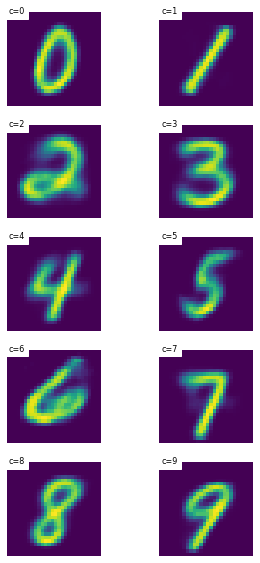

In [27]:
generate(vae)